# 2/28 checkpoint:

1. Data cleaning
    - Remove uncensored data (no event yet) -- clinical dataset
    - Filter for Morphologic, Intensity, Volumetric (pick 1 MMM…) -- radiomic dataset
2. Binary classifier threshold
    - Histogram of when patients die --> low vs high severity
3. Feature significance
    - P-value for each feature 
    - Covariance: correlation between features 

In [114]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn import metrics
from sklearn.model_selection import train_test_split
# from pysurvival.models.simulations import SimulationModel
# from pysurvival.models.survival_forest import ConditionalSurvivalForestModel
# from pysurvival.utils.metrics import concordance_index
# from pysurvival.utils.display import integrated_brier_score
import warnings
warnings.filterwarnings('ignore')
import eli5

In [115]:
from pycox.datasets import metabric
from pycox.models import MTLR
from pycox.evaluation import EvalSurv

In [116]:
# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

In [407]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression, Ridge
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from feature_engine.selection import RecursiveFeatureElimination
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [113]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [322]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [5]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [118]:
# read in data
clin_data = pd.read_csv("UPENN-GBM_clinical_info_v1.0.csv")
rad_data = pd.read_csv("radiomic_features_CaPTk/Radiomic_Features_CaPTk_automaticsegm_DSC_ap-rCBV_ED.csv") # only 1 for now
rad_data = rad_data.rename(columns={"SubjectID": "ID"})


## Data cleaning (clin):

In [119]:
# remove uncensored data
clean_clin = clin_data[clin_data.Survival_from_surgery_days != "Not Available"] # 671 --> 452 rows

# features: (ID), Gender, Age, Survival, IDH1, GTR, Time
clinical = clean_clin[["ID", "Gender", "Age_at_scan_years", "Survival_from_surgery_days", "IDH1", "GTR_over90percent", "Time_since_baseline_preop"]]
clinical = clinical[clin_data.GTR_over90percent != "Not Available"] # 452 --> 424 rows
clinical = clinical[clin_data.Time_since_baseline_preop != "Not Available"] # ? final rows


clin_res = clinical.reset_index(drop = True)
clin_res['Survival_from_surgery_days'] = clin_res['Survival_from_surgery_days'].astype('int')
clin_res['Time_since_baseline_preop'] = clin_res['Time_since_baseline_preop'].astype('int')

In [8]:
clin_res

,ID,Gender,Age_at_scan_years,Survival_from_surgery_days,IDH1,GTR_over90percent,Time_since_baseline_preop
0,UPENN-GBM-00002_11,F,61.30,291,Wildtype,Y,0
1,UPENN-GBM-00006_11,M,52.99,626,Wildtype,Y,0
2,UPENN-GBM-00008_11,F,55.06,469,Wildtype,Y,0
3,UPENN-GBM-00009_11,M,69.12,561,Wildtype,Y,0
4,UPENN-GBM-00011_11,F,39.61,798,NOS/NEC,Y,0
...,...,...,...,...,...,...,...
419,UPENN-GBM-00593_11,M,57.82,223,Wildtype,N,0
420,UPENN-GBM-00597_11,F,61.92,381,Wildtype,Y,0
421,UPENN-GBM-00601_11,M,59.69,435,Wildtype,Y,0
422,UPENN-GBM-00609_11,M,29.01,138,Wildtype,N,0


In [120]:
comb_data = clin_res.merge(rad_data, how = 'inner', on = ['ID'])

## Severity threshold (clin):

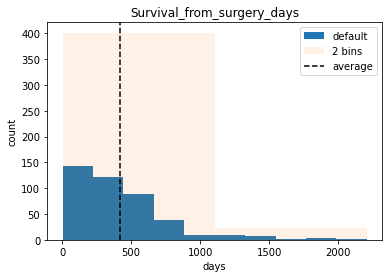

In [10]:
# Histogram of survival_from_surgery_days
plt.hist(clin_res['Survival_from_surgery_days'], alpha=1, label='default')
plt.hist(clin_res['Survival_from_surgery_days'], bins=2, alpha=0.1, label='2 bins')

# find a threshold that splits the data evenly
avg_days = np.mean(clin_res['Survival_from_surgery_days'])
plt.axvline(x = avg_days, color = "black", linestyle = '--', label = 'average')

plt.legend(loc='upper right')
plt.title("Survival_from_surgery_days")
plt.xlabel("days")
plt.ylabel("count")
plt.show()

In [121]:
# add a class that indicates whether patient is low or high severity based on average threshold
clin_res['severity_class'] = np.where(clin_res['Survival_from_surgery_days'] >= avg_days, 'low', 'high')

## Feature exploration (clin):

### P-value

In [67]:
cat_columns = clin_res.select_dtypes(['object']).columns
clin_res[cat_columns] = clin_res[cat_columns].apply(lambda x: pd.factorize(x)[0])
clin_res

,ID,Gender,Age_at_scan_years,Survival_from_surgery_days,IDH1,GTR_over90percent,Time_since_baseline_preop
0,0,0,61.30,291,0,0,0
1,1,1,52.99,626,0,0,0
2,2,0,55.06,469,0,0,0
3,3,1,69.12,561,0,0,0
4,4,0,39.61,798,1,0,0
...,...,...,...,...,...,...,...
419,419,1,57.82,223,0,1,0
420,420,0,61.92,381,0,0,0
421,421,1,59.69,435,0,0,0
422,422,1,29.01,138,0,1,0


In [13]:
# p value for each feature
x = clin_res[clin_res.columns[clin_res.columns != 'severity_class']] # use as target
x = clin_res[clin_res.columns[clin_res.columns != 'ID']] # not a feature
y = clin_res.severity_class 
 
# Statsmodels.OLS requires us to add a constant.
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary()) # Age & Survival from surgery days are only significant categories (p < 0.05)

                            OLS Regression Results                            
Dep. Variable:         severity_class   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.507e+30
Date:                Wed, 12 Apr 2023   Prob (F-statistic):               0.00
Time:                        20:35:53   Log-Likelihood:                 13638.
No. Observations:                 424   AIC:                        -2.726e+04
Df Residuals:                     417   BIC:                        -2.723e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

### Feature correlation (clin)

In [68]:
x_conf = x[['Gender', 'Age_at_scan_years', 'Survival_from_surgery_days', 'IDH1', 'GTR_over90percent', 'severity_class']]

<Axes: >

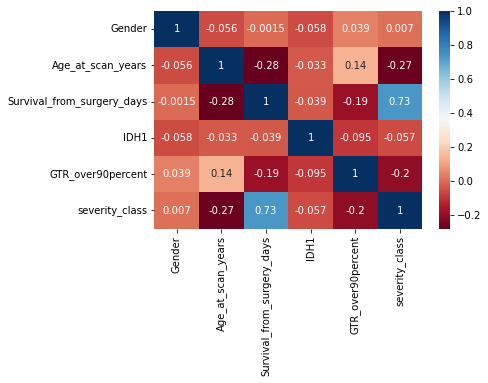

In [15]:
# should not use features highly correlated with each other in same model
sns.heatmap(x_conf.corr(),annot=True, cmap = 'RdBu')

In [16]:
x_conf.corr().unstack().sort_values(kind="quicksort") 

Survival_from_surgery_days  Age_at_scan_years            -0.279543
Age_at_scan_years           Survival_from_surgery_days   -0.279543
severity_class              Age_at_scan_years            -0.265800
Age_at_scan_years           severity_class               -0.265800
severity_class              GTR_over90percent            -0.204816
GTR_over90percent           severity_class               -0.204816
Survival_from_surgery_days  GTR_over90percent            -0.192972
GTR_over90percent           Survival_from_surgery_days   -0.192972
IDH1                        GTR_over90percent            -0.094998
GTR_over90percent           IDH1                         -0.094998
IDH1                        Gender                       -0.058232
Gender                      IDH1                         -0.058232
IDH1                        severity_class               -0.057471
severity_class              IDH1                         -0.057471
Gender                      Age_at_scan_years            -0.05

TODO:
- (Filter for Morphologic, Intensity, Volumetric (pick 1 MMM…) -- radiomic dataset)

# TO DO:
1. rerun test w/ radiomics data (select m features from n features --> use N-MTLR to compare accuracies)
2. SVD (follow GitHub example)
3. conditional survival forest (time/cost, metric - DL divergence, number of features selected, AUC)
Notes: keep time as variable when training

# Tue, 4/11:
1. train N-MTLR model on all data vs. on t-test selected features (compare performance & time)
2. start SVD exploration

### N-MTLR

In [17]:
# comb_data.to_csv('all_features.csv')

## FEATURE SELECTION ALGORITHMS

1. Filter:
- t-test (DONE)

2. Wrapper:
- Recursive feature elimination (DONE)
- Sequential forward selection (DONE)

3. Embedded:
- Lasso (DONE)
- Tree (DONE)
- Ridge (DONE)
- SVM (DONE)

4. All variables - no selection (DONE)

In [307]:
comb_data_new = comb_data.dropna(axis=0) # remove any rows with NAN
comb_data_new = comb_data_new.set_index('ID') # make ID index

In [308]:
# convert categorical columns to numerical
cat_columns = comb_data_new.select_dtypes(['object']).columns
comb_data_new[cat_columns] = comb_data_new[cat_columns].apply(lambda x: pd.factorize(x)[0])

In [124]:
features = comb_data_new.loc[:, comb_data_new.columns != "Survival_from_surgery_days"]
target = comb_data_new['Survival_from_surgery_days']

In [125]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=0)

# WRAPPER:

### Recursive feature elimination:

In [80]:
model = GradientBoostingRegressor(
    n_estimators=5,
    random_state=10,
)

RFE_model = RecursiveFeatureElimination(
    estimator = model, # the ML model
    scoring = 'r2', 
    threshold = 0.05, 
    cv=2,
)

RFE_model.fit(X_train, y_train)

RFE_model.feature_importances_[140:149]

DSC_ap-rCBV_ED_GLSZM_Bins-16_Radius-1_GreyLevelNonUniformity    0.038182
DSC_ap-rCBV_ED_Intensity_CoefficientOfVariation                 0.043069
DSC_ap-rCBV_ED_GLSZM_Bins-16_Radius-1_ZoneSizeNonUniformity     0.045662
DSC_ap-rCBV_ED_Morphologic_EquivalentSphericalRadius            0.046481
DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Bin-15_Probability     0.048436
DSC_ap-rCBV_ED_GLRLM_Bins-16_Radius-1_LongRunEmphasis           0.065915
DSC_ap-rCBV_ED_Intensity_Median                                 0.067031
DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Bin-0_Frequency        0.117428
Age_at_scan_years                                               0.239733
dtype: float64

### Sequential forward selection:

In [414]:
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [415]:
knn = KNeighborsClassifier(n_neighbors=4)

In [416]:
sfs1 = SFS(knn, 
           k_features=3, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=0)

sfs1 = sfs1.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 149 out of 149 | elapsed:    0.7s finished

[2023-04-20 22:59:36] Features: 1/3 -- score: 0.28448275862068967[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 148 out of 148 | elapsed:    0.7s finished

[2023-04-20 22:59:37] Features: 2/3 -- score: 0.28448275862068967[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed:    0.7s finished

[2023-04-20 22:59:38] Features: 3/3 -- score: 0.28448275862068967

In [417]:
sfs1.k_feature_names_

('Gender', 'Age_at_scan_years', 'DSC_ap-rCBV_ED_Intensity_Sum')

In [418]:
SFS_features = ['Gender', 'Age_at_scan_years', 'DSC_ap-rCBV_ED_Intensity_Sum']

# EMBEDDED:

### Lasso:

In [43]:
# # standardize features?
# std = np.std(non_bin, axis=0)
# non_bin /= std

In [46]:
regressor = linear_model.Lasso(alpha=5000,
                               positive=True,
                               fit_intercept=False, 
                               max_iter=1000,
                               tol=0.0001)
regressor.fit(X_train, y_train)

Lasso(alpha=5000, fit_intercept=False, positive=True)

In [27]:
eli5.show_weights(regressor, top=-1, feature_names = X_train.columns.tolist())

Weight?,Feature
+0.604,DSC_ap-rCBV_ED_NGTDM_Complexity
+0.020,DSC_ap-rCBV_ED_GLCM_Bins-16_Radius-1_ClusterProminence
+0.014,DSC_ap-rCBV_ED_Intensity_Variance
+0.007,DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Bin-2_Frequency
+0.001,DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Bin-0_Frequency
+0.000,DSC_ap-rCBV_ED_Morphologic_EquivalentSphericalPerimeter
+0.000,DSC_ap-rCBV_ED_GLSZM_Bins-16_Radius-1_LargeZoneLowGreyLevelEmphasis


### Ridge:

In [408]:
# use X_train_std
ridge = linear_model.Ridge(alpha=5000,
                               positive=True,
                               fit_intercept=False, 
                               max_iter=1000,
                               tol=0.0001)
ridge.fit(X_train_std, y_train)

Ridge(alpha=5000, fit_intercept=False, max_iter=1000, positive=True)

In [410]:
ridge_features = ['DSC_ap-rCBV_ED_Morphologic_Roundness', 'DSC_ap-rCBV_ED_GLSZM_Bins-16_Radius-1_LargeZoneLowGreyLevelEmphasis', 
                 'DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation', 'DSC_ap-rCBV_ED_GLSZM_Bins-16_Radius-1_ZoneSizeVariance', 
                 'DSC_ap-rCBV_ED_GLSZM_Bins-16_Radius-1_LargeZoneEmphasis', 'DSC_ap-rCBV_ED_Morphologic_EllipseDiameter_Axis-0']

In [409]:
eli5.show_weights(ridge, top=-1, feature_names = X_train.columns.tolist())

Weight?,Feature
+2.394,DSC_ap-rCBV_ED_Morphologic_Roundness
+2.039,DSC_ap-rCBV_ED_GLSZM_Bins-16_Radius-1_LargeZoneLowGreyLevelEmphasis
+1.876,DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation
+1.819,DSC_ap-rCBV_ED_GLSZM_Bins-16_Radius-1_ZoneSizeVariance
+1.816,DSC_ap-rCBV_ED_GLSZM_Bins-16_Radius-1_LargeZoneEmphasis
+1.761,DSC_ap-rCBV_ED_Morphologic_EllipseDiameter_Axis-0
+1.491,DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Bin-0_Frequency
+1.374,DSC_ap-rCBV_ED_NGTDM_Busyness
+1.370,DSC_ap-rCBV_ED_GLCM_Bins-16_Radius-1_Energy
+1.352,DSC_ap-rCBV_ED_GLSZM_Bins-16_Radius-1_LargeZoneHighGreyLevelEmphasis


### SVM:

In [428]:
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

Text(0.5, 0, 'Permutation Importance')

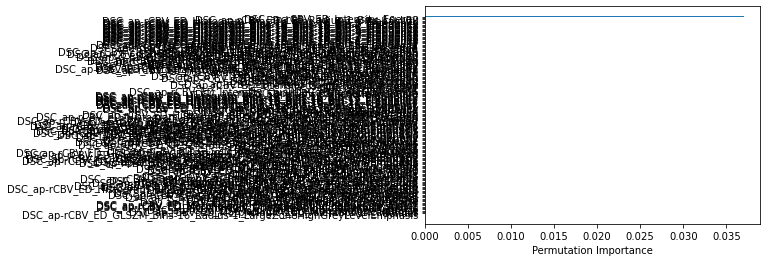

In [441]:
svc =  SVC(kernel='rbf', C=2)
svc.fit(X_train, y_train)

perm_importance = permutation_importance(svc, X_train, y_train)

feature_names = X_train.columns.tolist()
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [442]:
svm_features = ["Gender"]

### Tree (Random Forest):

In [144]:
# scale features???
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)

In [175]:
forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X_train_std, y_train.values.ravel())

RandomForestClassifier(n_estimators=500, random_state=1)

In [176]:
importances = forest.feature_importances_
sorted_indices = np.argsort(importances)[::-1] # descending order
feat_labels = X_train.columns[1:]
for f in range(25):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[sorted_indices[f]], importances[sorted_indices[f]]))

 1) DSC_ap-rCBV_ED_Morphologic_LargestComponentSize 0.013867
 2) IDH1                           0.013795
 3) DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Median 0.013524
 4) DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Minimum 0.013477
 5) DSC_ap-rCBV_ED_GLCM_Bins-16_Radius-1_AutoCorrelation 0.013144
 6) DSC_ap-rCBV_ED_Intensity_Median 0.013087
 7) DSC_ap-rCBV_ED_GLSZM_Bins-16_Radius-1_SmallZoneEmphasis 0.011478
 8) DSC_ap-rCBV_ED_GLRLM_Bins-16_Radius-1_LongRunHighGreyLevelEmphasis 0.011139
 9) DSC_ap-rCBV_ED_GLSZM_Bins-16_Radius-1_ZonePercentage 0.011061
10) DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Bin-1_Frequency 0.010914
11) DSC_ap-rCBV_ED_Intensity_Minimum 0.010819
12) DSC_ap-rCBV_ED_Morphologic_EquivalentSphericalPerimeter 0.010818
13) DSC_ap-rCBV_ED_GLSZM_Bins-16_Radius-1_HighGreyLevelEmphasis 0.010597
14) DSC_ap-rCBV_ED_GLRLM_Bins-16_Radius-1_LowGreyLevelRunEmphasis 0.010315
15) DSC_ap-rCBV_ED_Morphologic_EllipseDiameter_Axis-0 0.010186
16) DSC_ap-rCBV_ED_GLSZM_Bins-16_Radius-1_GreyLeve

In [167]:
# to avoid randomness, get results a few times and take intersection

## FILTER:

### T-Test:

In [184]:
X_train = sm.add_constant(X_train)
model_ols = sm.OLS(y_train, X_train).fit()

d = {}
for i in X_train.columns.tolist():
    d[f'{i}'] = model_ols.pvalues[i]

df_pvalue= pd.DataFrame(d.items(), columns=['Var_name', 'p-Value']).sort_values(by = 'p-Value').reset_index(drop=True)

# df_pvalue[0:52]

# TSNE visulization:

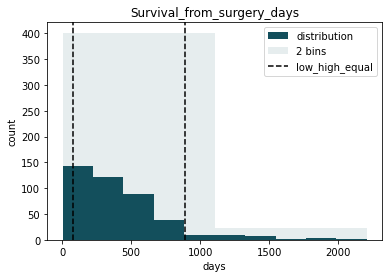

In [448]:
# create a class for low vs. high severity (add medium if not good)

# Histogram of survival_from_surgery_days
plt.hist(clin_res['Survival_from_surgery_days'], alpha=1, label='distribution', color = "#134f5cff")
plt.hist(clin_res['Survival_from_surgery_days'], bins=2, alpha=0.1, label='2 bins', color = "#134f5cff")

# find a threshold that splits the data evenly
avg_days = np.mean(clin_res['Survival_from_surgery_days'])
plt.axvline(x = 890, color = "black", linestyle = '--')
plt.axvline(x = 80, color = "black", linestyle = '--', label = 'low_high_equal')

plt.legend(loc='upper right')
plt.title("Survival_from_surgery_days")
plt.xlabel("days")
plt.ylabel("count")
plt.show()

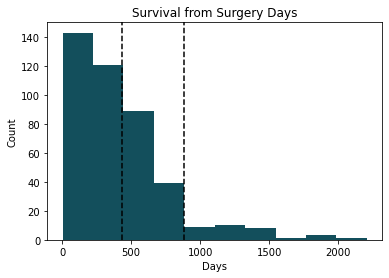

In [465]:
# create a class for low vs. high severity (add medium if not good)

# Histogram of survival_from_surgery_days
plt.hist(clin_res['Survival_from_surgery_days'], alpha=1, label='distribution', color = "#134f5cff")
# plt.hist(clin_res['Survival_from_surgery_days'], bins=2, alpha=0.1, label='2 bins', color = "#134f5cff")

# find a threshold that splits the data evenly
avg_days = np.mean(clin_res['Survival_from_surgery_days'])
plt.axvline(x = 880, color = "black", linestyle = '--')
plt.axvline(x = 430, color = "black", linestyle = '--')

# plt.legend(loc='upper right')
plt.title("Survival from Surgery Days")
plt.xlabel("Days")
plt.ylabel("Count")
plt.show()

In [449]:
clin_res

,ID,Gender,Age_at_scan_years,Survival_from_surgery_days,IDH1,GTR_over90percent,Time_since_baseline_preop,severity_class
0,UPENN-GBM-00002_11,F,61.30,291,Wildtype,Y,0,high
1,UPENN-GBM-00006_11,M,52.99,626,Wildtype,Y,0,low
2,UPENN-GBM-00008_11,F,55.06,469,Wildtype,Y,0,low
3,UPENN-GBM-00009_11,M,69.12,561,Wildtype,Y,0,low
4,UPENN-GBM-00011_11,F,39.61,798,NOS/NEC,Y,0,low
...,...,...,...,...,...,...,...,...
419,UPENN-GBM-00593_11,M,57.82,223,Wildtype,N,0,high
420,UPENN-GBM-00597_11,F,61.92,381,Wildtype,Y,0,high
421,UPENN-GBM-00601_11,M,59.69,435,Wildtype,Y,0,low
422,UPENN-GBM-00609_11,M,29.01,138,Wildtype,N,0,high


In [347]:
# low is 0, medium is 1, high is 2
low = np.where(comb_data_new['Survival_from_surgery_days'] > 890)
# medium = np.where((comb_data_new['Survival_from_surgery_days'] > 435) & (comb_data_new['Survival_from_surgery_days'] <= 875))
high = np.where(comb_data_new['Survival_from_surgery_days'] <= 60)

In [349]:
len(low[0])

28

In [350]:
comb_data_new.loc[comb_data_new.index[low], 'severity_class'] = 0
# comb_data_new.loc[comb_data_new.index[medium], 'severity_class'] = 1
comb_data_new.loc[comb_data_new.index[high], 'severity_class'] = 2

In [352]:
X_rem = comb_data_new.loc[:, comb_data_new.columns != "severity_class"]

X_all = X_rem.loc[:, X_rem.columns != 'Survival_from_surgery_days']
y_all = comb_data_new['severity_class']

In [320]:
def plot_tsne(n, X_data, y_data, title):
    n_components = n
    tsne = TSNE(n_components)
    tsne_result = tsne.fit_transform(X_data)
    
    tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,1], 'tsne_2': tsne_result[:,2], 'label': y_data})
    fig, ax = plt.subplots(1)
    sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=10, palette = "tab10")
    lim = (tsne_result.min()-5, tsne_result.max()+5)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    plt.title(title)

In [353]:
n_components = 3
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(X_all)
tsne_result.shape

(310, 3)

In [333]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 6,4

Text(0.5, 1.0, 'TSNE (all features)')

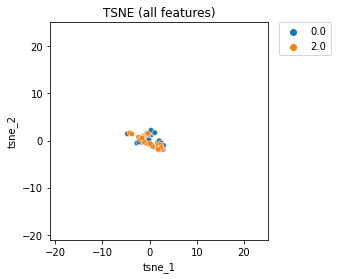

In [354]:
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,1], 'tsne_2': tsne_result[:,2], 'label': y_all})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=30, palette = "tab10")
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.title("TSNE (all features)")

In [ ]:
# only look at 0 and 2 -- 

# PCA: 

In [400]:
def plot_PCA(X_data, y_data, title):
    pca = PCA()
    Xt = pca.fit_transform(X_data)
    plt.scatter(Xt[:,0], Xt[:,1], c=y_data, cmap='Paired')
    direction = pca.components_[0]
    # plt.plot([0, direction[0]], [0, direction[1]], 'k-', linewidth=2) # plot best separation line
    plt.title(title)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    # plt.legend(handles=plot.legend_elements()[0], labels=y_data)
    plt.show()

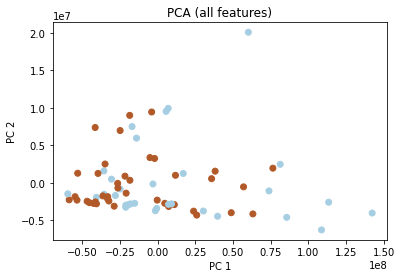

In [397]:
plot_PCA(X_all, y_all, "PCA (all features)")

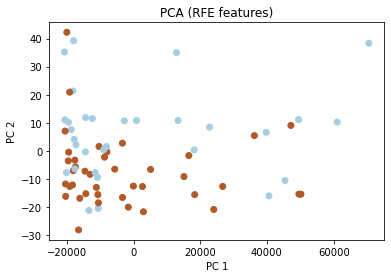

In [401]:
plot_PCA(X_RFE, y_all, "PCA (RFE features)")

In [357]:
tree_features = ['DSC_ap-rCBV_ED_Morphologic_LargestComponentSize', 
            'IDH1', 'DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Median',
            'DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Minimum',
            'DSC_ap-rCBV_ED_GLCM_Bins-16_Radius-1_AutoCorrelation',
            'DSC_ap-rCBV_ED_Intensity_Median']
X_tree = X_all[tree_features]

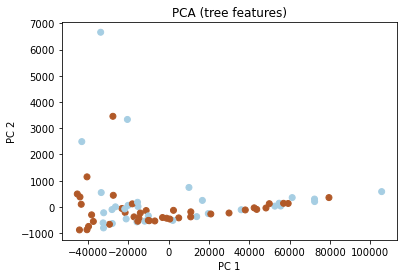

In [399]:
plot_PCA(X_tree, y_all, "PCA (tree features)")

In [403]:
lasso_features = ['DSC_ap-rCBV_ED_NGTDM_Complexity',
            'DSC_ap-rCBV_ED_GLCM_Bins-16_Radius-1_ClusterProminence',
            'DSC_ap-rCBV_ED_Intensity_Variance',
            'DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Bin-2_Frequency',
            'DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Bin-0_Frequency']
X_lasso = X_all[lasso_features]

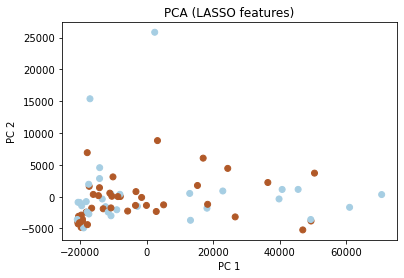

In [404]:
plot_PCA(X_lasso, y_all, "PCA (LASSO features)")

In [405]:
ttest_features = ['Age_at_scan_years',
 'DSC_ap-rCBV_ED_Morphologic_EllipseDiameter_Axis-2',
 'DSC_ap-rCBV_ED_Morphologic_Elongation',
 'DSC_ap-rCBV_ED_Morphologic_Flatness',
 'DSC_ap-rCBV_ED_Morphologic_EllipseDiameter_Axis-1',
 'DSC_ap-rCBV_ED_Morphologic_EquivalentSphericalRadius',
 'DSC_ap-rCBV_ED_Morphologic_EllipseDiameter_Axis-0',
 'DSC_ap-rCBV_ED_GLSZM_Bins-16_Radius-1_SmallZoneLowGreyLevelEmphasis',
 'DSC_ap-rCBV_ED_Intensity_StandardDeviation',
 'DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Bin-13_Frequency',
 'DSC_ap-rCBV_ED_Intensity_Range',
 'DSC_ap-rCBV_ED_NGTDM_Strength',
 'DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Bin-9_Frequency',
 'DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Skewness',
 'DSC_ap-rCBV_ED_Intensity_Median',
 'DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Bin-11_Frequency',
 'DSC_ap-rCBV_ED_Morphologic_PerimeterOnBorderRatio',
 'DSC_ap-rCBV_ED_NGTDM_Coarsness',
 'DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Bin-7_Frequency',
 'Time_since_baseline_preop',
 'DSC_ap-rCBV_ED_Morphologic_LargestComponentSize',
 'DSC_ap-rCBV_ED_Morphologic_PixelsOnBorder',
 'DSC_ap-rCBV_ED_Morphologic_NumberOfPixels',
 'DSC_ap-rCBV_ED_Morphologic_OrientedBoundingBoxSize_Axis-0',
 'DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Bin-1_Frequency',
 'DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_MeanAbsoluteDeviation',
 'DSC_ap-rCBV_ED_Morphologic_PhysicalSize',
 'DSC_ap-rCBV_ED_Morphologic_OrientedBoundingBoxSize_Axis-2',
 'DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Minimum',
 'DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Bin-2_Frequency',
 'DSC_ap-rCBV_ED_Intensity_MeanAbsoluteDeviation',
 'DSC_ap-rCBV_ED_Morphologic_PerimeterOnBorder',
 'DSC_ap-rCBV_ED_Morphologic_OrientedBoundingBoxSize_Axis-1',
 'DSC_ap-rCBV_ED_Volumetric_Volume',
 'DSC_ap-rCBV_ED_Volumetric_Pixels',
 'DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Bin-0_Frequency',
 'DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Bin-3_Frequency',
 'DSC_ap-rCBV_ED_Intensity_Maximum',
 'DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Bin-8_Frequency',
 'DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Sum',
 'DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Bin-5_Frequency',
 'DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Bin-15_Frequency',
 'DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Bin-10_Frequency',
 'DSC_ap-rCBV_ED_Intensity_Minimum',
 'DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Bin-6_Frequency',
 'DSC_ap-rCBV_ED_GLSZM_Bins-16_Radius-1_LargeZoneHighGreyLevelEmphasis',
 'DSC_ap-rCBV_ED_GLSZM_Bins-16_Radius-1_ZoneSizeMean',
 'DSC_ap-rCBV_ED_Intensity_Skewness',
 'DSC_ap-rCBV_ED_Intensity_MedianAbsoluteDeviation',
 'DSC_ap-rCBV_ED_Morphologic_Eccentricity',
 'DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Bin-5_Probability',
 'DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_Energy']

X_ttest = X_all[ttest_features]

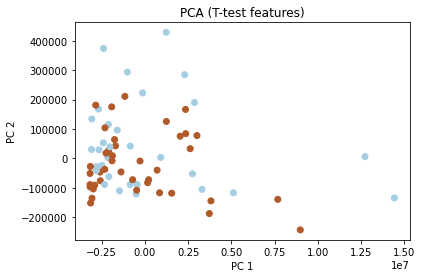

In [406]:
plot_PCA(X_ttest, y_all, "PCA (T-test features)")

In [454]:
X_ridge = X_all[ridge_features]

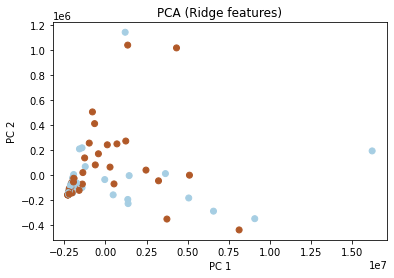

In [455]:
plot_PCA(X_ridge, y_all, "PCA (Ridge features)")

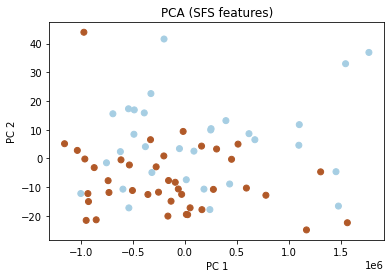

In [456]:
X_SFS = X_all[SFS_features]
plot_PCA(X_SFS, y_all, "PCA (SFS features)")